REFERENCES
1. https://towardsdatascience.com/creating-image-classification-model-with-bayesian-perspective-a90a5956b14e
2. https://keras.io/examples/keras_recipes/bayesian_neural_networks/

# Importing Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Unzip image file data**

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/COSC2673 - Machine Learning Assignment 2/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
# This is extra code for unzipping
!gdown https://drive.google.com/uc?id=1Ypdy3Tzl8TTudbbuJqWfmnhcblTXG-y1 -O data.zip
!unzip -qq data.zip

Downloading...
From: https://drive.google.com/uc?id=1Ypdy3Tzl8TTudbbuJqWfmnhcblTXG-y1
To: /content/data.zip
40.7MB [00:00, 112MB/s]


#### **Reading 'mainData' CSV file**

In [16]:
import os
import glob
import shutil
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation,
    Dense, Dropout, MaxPooling2D, Flatten,
    ZeroPadding2D, Input, GlobalAveragePooling2D,
    AveragePooling2D, Add)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import f1_score,precision_score,recall_score
from matplotlib import pyplot as plt

%matplotlib inline

%matplotlib inline

In [4]:
# import numpy as np
# from matplotlib import pyplot as plt
# import pandas as pd

#data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data = pd.read_csv('/content/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Exploratory Data Analysis

Trends in the .csv file are explored and visualised to determine effective approaches for the model as well as what general predictions the model may make.



In [ ]:
# Checking if any NaN values are in the dataset
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

#### **Data Balance and Imbalance**

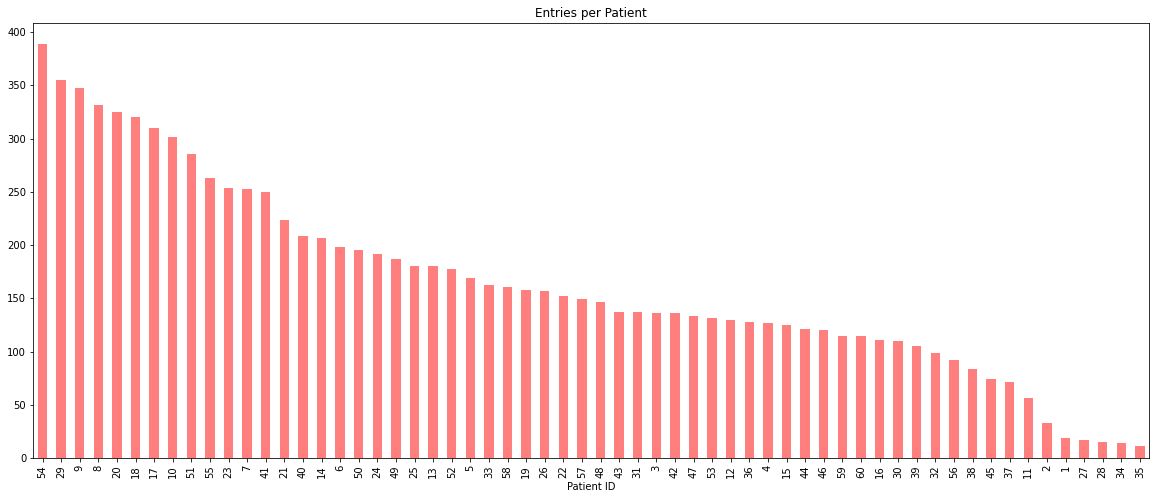

In [ ]:
# Plot the number of entries within the data set per patient
plt.figure(figsize=(20,8))
data['patientID'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)
plt.title("Entries per Patient")
plt.xticks(rotation='vertical')
plt.xlabel("Patient ID")

plt.show()

From the above data, it can be seen that the number of datapoints per patient (a total of 60 patients in the main data set) varies greatly between a range of roughly 10 to 400, making it unbalanced.

Another thing to take into account is that although it is normally expected that ID values should not have influence over the training of a machine learning model, datapoints in this case can originate from the same patient, adding bias to the data. This would eventuate data leaks between the test and training data sets if patient ID is not taken into account when splitting. 

In saying this, a possible solution to this would be to perform splits while ensuring that datapoints from the same patient ID are kept grouped together. For example, all datapoints from patients 1, 2, 3, 4, 5 can be set aside for training and datapoints from patients 6, 7, 8, 9, 10 can be set aside for testing (given that the number of datapoints within the split data sets are proportioned)

=======================================================

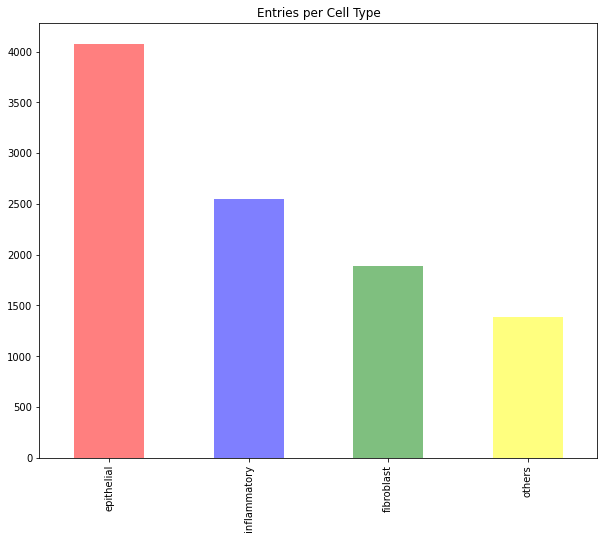

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64


In [ ]:
# Plot the number of entries within the data set per cell type
plt.figure(figsize=(10,8))
data['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red', 'blue', 'green', 'yellow'], alpha=0.5)
plt.title("Entries per Cell Type")
plt.xticks(rotation='vertical')

plt.show()

print(data['cellTypeName'].value_counts())

It can be see that there is an imbalance in the frequencies of the different cell types, however, apart from the 'others' type, there is only little difference.

=======================================================

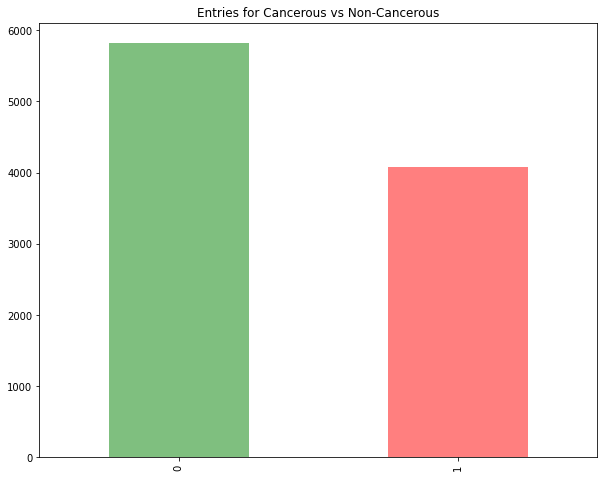

0    5817
1    4079
Name: isCancerous, dtype: int64


In [ ]:
# Plot the number of entries within the data set based on whether the cell is cancerous or not
plt.figure(figsize=(10,8))
data['isCancerous'].value_counts().plot(kind='bar', rot=0, color=['green', 'red'], alpha=0.5)
plt.title("Entries for Cancerous vs Non-Cancerous")
plt.xticks(rotation='vertical')

plt.show()

print(data['isCancerous'].value_counts())

Above, there is an imbalance in the frequencies of datapoints that are labelled cancerous and non-cancerous, however this can be considered a small difference and is expected to cause little influence on the training of the model.

#### **Frequency of Cancerous & Non-Cancerous Cells vs Cell Type**

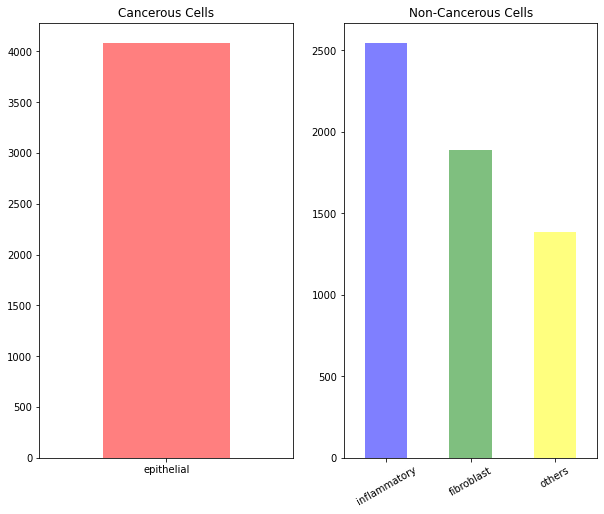

In [ ]:
# Split data into cancerous and non-cancerous sets for plotting
cancerousCellData = data[data['isCancerous'] == 1]
nonCancerousCellData = data[data['isCancerous'] == 0]

# Plotting the number of cancerous and non-cancerous cells against cell type
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.title("Cancerous Cells")
cancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)

plt.subplot(1, 2, 2)
plt.title("Non-Cancerous Cells")
nonCancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['blue', 'green', 'yellow'], alpha=0.5)
plt.xticks(rotation=30)

plt.show()

From the above data, it can be seen that 100% of the cells that have been labelled cancerous have been labelled the epithelial cell type, while 100% of the non-cancerous cells are of inflammatory, fibroblast and other cell types.

This indicates that training a model with this data will cause it to predict cancerous cells to be of epithelial cell type and epithelial cells to be cancerous.

# Data Pre-Processing

In [ ]:
# Removes the 'InstanceID' column
data = data.drop(['InstanceID'], axis=1)

#### **REDUNDANT One-Hot Encoding**
Using one-hot encoding the split the categories of  'cellTypeName' into 4 separate columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder_cellTypeName = OneHotEncoder(handle_unknown='ignore')
OneHotEncoder_cellTypeName.fit(data[['cellTypeName']])

onehot_ = OneHotEncoder_cellTypeName.transform(data[['cellTypeName']]).toarray()

print(OneHotEncoder_cellTypeName.categories_)

colName = 'cellTypeName'
for i in range(len(OneHotEncoder_cellTypeName.categories_[0])):
    data['CellType_' + str(OneHotEncoder_cellTypeName.categories_[0][i])] = onehot_[:,i]

data = data.drop(['cellTypeName', 'cellType'], axis=1)
data.head()

[array(['epithelial', 'fibroblast', 'inflammatory', 'others'], dtype=object)]


,patientID,ImageName,isCancerous,CellType_epithelial,CellType_fibroblast,CellType_inflammatory,CellType_others
0,1,22405.png,0,0.0,1.0,0.0,0.0
1,1,22406.png,0,0.0,1.0,0.0,0.0
2,1,22407.png,0,0.0,1.0,0.0,0.0
3,1,22408.png,0,0.0,1.0,0.0,0.0
4,1,22409.png,0,0.0,1.0,0.0,0.0


#### **Data Splitting**
TODO: data should be split without leakage -> ie patient 1,2,3 for train, 4,5 for validation and 6 for testing.

In [ ]:
data.groupby(by='patientID').count()

,ImageName,isCancerous,CellType_epithelial,CellType_fibroblast,CellType_inflammatory,CellType_others
patientID,,,,,,
1,19,19,19,19,19,19
2,33,33,33,33,33,33
3,136,136,136,136,136,136
4,127,127,127,127,127,127
5,169,169,169,169,169,169
6,198,198,198,198,198,198
7,253,253,253,253,253,253
8,332,332,332,332,332,332
9,348,348,348,348,348,348


In [ ]:
# Split the data into train, validation and test 
from sklearn.model_selection import train_test_split
test_size = int(len(data) * 0.1)
val_size = int(len(data) * 0.1)
train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=42)

print("Train data: {} | Validation Data: {} | Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data: 7918 | Validation Data: 989 | Test Data: 989


# Classification of Cancerous Cells
Following is a model made designed to predict cancerous from non-cancerous cells.


In [ ]:
# Constant variables

IMAGE_SIZE = (27, 27)

# Images are 27x27 in size, and have 3 dimensions for the RGB colouring of each pixel
INPUT_DIM = (27, 27, 3)

# TESTING output for Cancerous & Non-Cancerous (2 classes)
OUTPUT_CLASSES = 2

#### **Image Data Generator**



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert types to string for the target value
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
val_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
test_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')

batch_size = 32 # 27

# Data generator for training set
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_data,
        #directory = './Image_classification_data/patch_images',
        directory = '/content/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary')

# Data generator for validation set
validation_generator = val_datagen.flow_from_dataframe(
        dataframe = val_data,
        #directory = './Image_classification_data/patch_images',
        directory = '/content/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary')


batch_size = 1

# Data generator for testing set
test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_data,
        #directory = './Image_classification_data/patch_images',
        directory = '/content/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary')

Found 7918 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### **Plot Learning Curve Function**

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Tan's Code for CNN

### Baseline Model
This is a baseline model for other model implementations to follow. It uses only tensorflow keras' neural network image learning with random data splitting.

In [ ]:
from tensorflow.keras.regularizers import l2
# A simple CNN with 2 layers
model_CNN = Sequential([
    # Layer 1
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    #Layer 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Flattening Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
  
])

# print out model summary and how many layers it has
model_CNN.summary()

# Build the model using defined architecture 
#1e-3

model_CNN.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
hist = model_CNN.fit(
    train_generator,
    batch_size=32,
    epochs=60,
    validation_data=validation_generator,
    verbose=1
)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               295040    
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

In [ ]:
# Plot the learning curve 
def plot(hist):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist.epoch, hist.history['accuracy'], label='training')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist.epoch, hist.history['loss'], label='training')
    plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

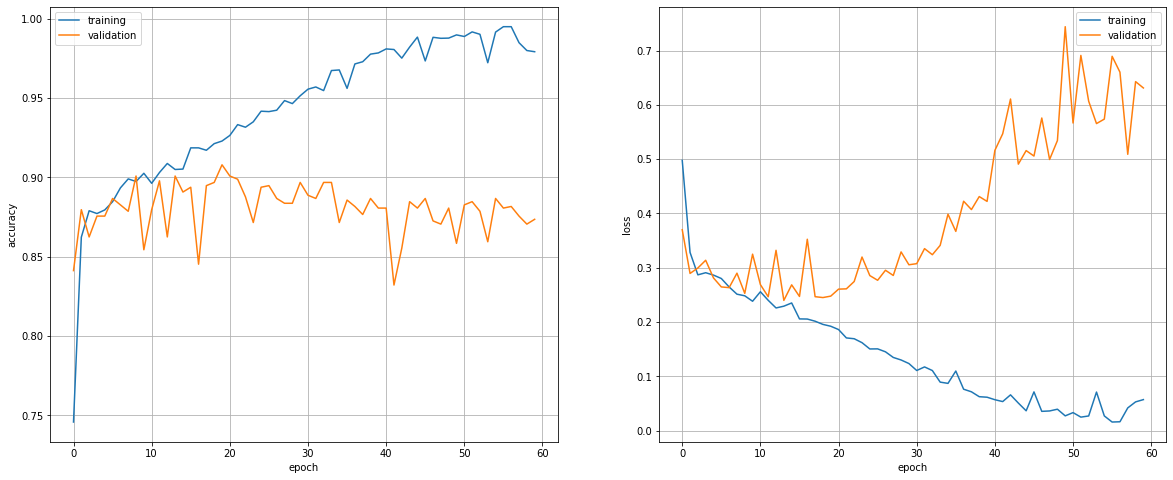

In [ ]:
plot(hist)

In [ ]:
# Predict using base model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5
for x,y in validation_generator:
    
        y_hat = model_CNN.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8796764408493428
F1 score:  0.8735317221095705
[[544  38]
 [ 81 326]]


### VGG

In [ ]:
# Define VGG Architecture 
def VGG_n(input_shape, num_classes, include_top=True):
    """
    """
    model_vgg = Sequential([
        # Input layer 
        Input(input_shape),

        # Layer 1
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 2
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Layer 3
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 4
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Flatening Layer
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.5),
    ])
    # sigmoid condition
    if include_top:
        model_vgg.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))
    return model_vgg

In [ ]:
# Build the model 
input_shape = (27, 27, 3)
model_VGG = VGG_n(input_shape, 1)
model_VGG.summary()

# Learning rate scheduler
learning_rate = 1e-3
# warmup_steps = 100
lr_drop = 25
epochs = 60

# Learning Rate Scheduler 
def lr_scheduler(epoch):
 return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)


# Compile the model
model_VGG.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg = model_VGG.fit(
    train_generator,
    batch_size=128,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 32)      

In [ ]:
# Plot the learning curve 
def plot(hist_vgg):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_vgg.epoch, hist_vgg.history['accuracy'], label='training')
    plt.plot(hist_vgg.epoch, hist_vgg.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_vgg.epoch, hist_vgg.history['loss'], label='training')
    plt.plot(hist_vgg.epoch, hist_vgg.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

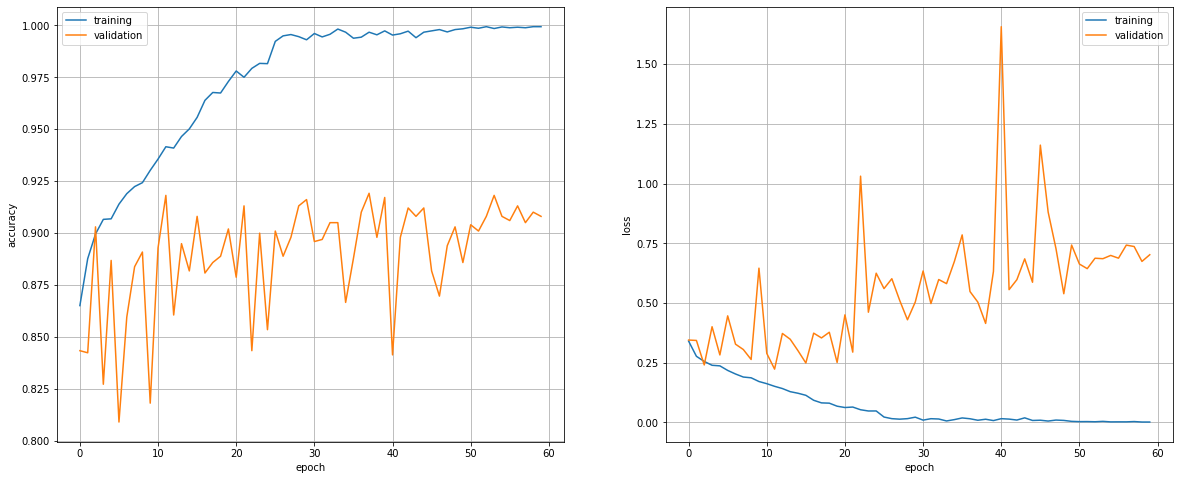

In [ ]:
plot(hist_vgg)

In [ ]:
# Predict using VGG_4 model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5
for x,y in validation_generator:
    
        y_hat = model_VGG.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [ ]:
# Print F1 Score, Confusion Matrix and Accuracy Score 
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9130434782608695
F1 score:  0.9105538355403746
[[534  42]
 [ 44 369]]


### Data Augmentation for performnace improvement 

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last',    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening= False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flig images 
    fill_mode='nearest'
    )   
batch_size = 128
train_vgg_generator = train_datagen.flow_from_dataframe(
        dataframe = train_data,
        #directory = './Image_classification_data/patch_images',
        directory = '/content/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary')

Found 7918 validated image filenames belonging to 2 classes.


In [ ]:
# Build the model 
input_shape = (27, 27, 3)
model_VGG_aug = VGG_n(input_shape, 1)
model_VGG_aug.summary()

# Learning rate scheduler
learning_rate = 1e-3
# warmup_steps = 100
lr_drop = 25
epochs = 200

def lr_scheduler(epoch):
 return learning_rate * (0.5 ** (epoch // lr_drop))
 reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
 lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)



# Compile the model
model_VGG_aug.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg = model_VGG_aug.fit(
    train_vgg_generator,
    batch_size=128,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_47 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_47 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_48 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_48 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 13, 13, 32)      

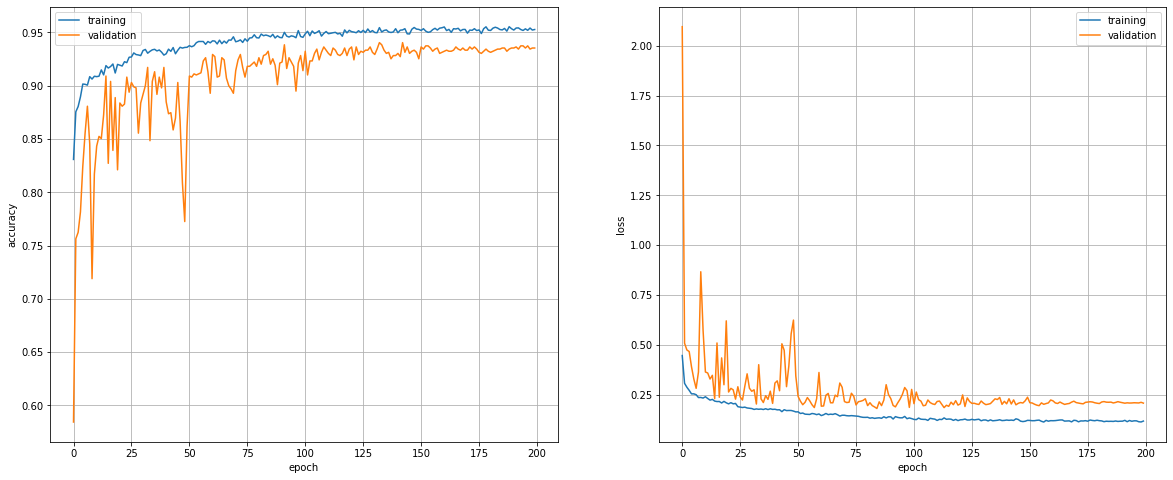

In [ ]:
plot(hist_vgg)

In [ ]:
# Predict using VGG_4 model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5
for x,y in validation_generator:
    
        y_hat = model_VGG_aug.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [ ]:
# Print F1 Score, Confusion Matrix and Accuracy Score 
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
cm= confusion_matrix(y_true=y_all, y_pred=y_hat_all)
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9383215369059656
F1 score:  0.9362567186194116
[[553  22]
 [ 39 375]]


In [ ]:
# Plot Confusion Matrix (Adapted from sikit learn)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['not_cancerous','cancerous']

Confusion matrix, without normalization
[[553  22]
 [ 39 375]]


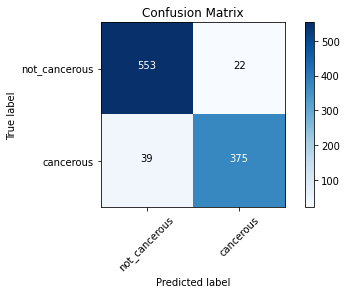

In [ ]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

From the confusion matirx:  
=> For Validation_data:
* TN=553,FP=22
* FN=39,TP=375


### Model Evaluation on test data 

In [ ]:
# Model Evaluation on test set
test_loss, test_accuracy=model_VGG_aug.evaluate(test_generator)
print('Test loss: {} Test accuracy: {}'.format(test_loss, test_accuracy))

989/989 [==============================] - 4s 4ms/step - loss: 0.2242 - accuracy: 0.9333
Test loss: 0.22423695027828217 Test accuracy: 0.9332659244537354


In [ ]:
# Predict using VGG_4 model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5 # Decision threshold 
for x,y in test_generator:
    
        y_hat = model_VGG_aug.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [ ]:
# Print F1 Score, Confusion Matrix and Accuracy Score 
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
cm= confusion_matrix(y_true=y_all, y_pred=y_hat_all)
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9332659251769464
F1 score:  0.9309532876364559
[[552  32]
 [ 34 371]]


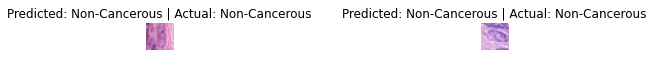

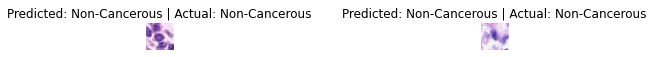

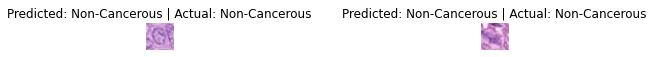

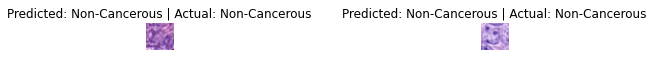

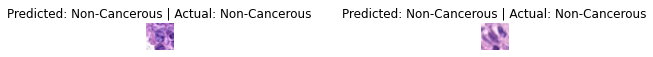

In [ ]:
# Plot the predicted results against the actual data on the test set
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

z = 0
while z < 5:
  d_inv = {v: k for k, v in label_names.items()}
  plt.figure(figsize=(17, 0.5))
  batches = 0
  for x, y in test_generator:
          batches = batches + 1
          y_hat = model_VGG_aug.predict(x, verbose=0)
          y_hat = np.squeeze(y_hat, 1)
          x = np.squeeze(x)
          if batches < 3:
              plt.subplot(1, 3, batches)
              plt.imshow(x)
              plt.title("Predicted: {} | Actual: {}".format(d_inv[np.argmax(y_hat[0])], d_inv[np.argmax(y[0])]))
              
          else:
              break
          
          plt.axis('off')

  z = z + 1

### Task 2: cellType Classification 

Data Preparation 

In [9]:
data_dir = Path('/content')
train_label_path = data_dir / 'data_labels_mainData.csv'

train_label_df = pd.read_csv(train_label_path)


train_label_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [23]:
# Data Loader 
def load_categorical_data(label_df, image_dir):
    """Load data from given label data frame and image dir

    Args
    label_df:
    image_dir:

    Returns
    """
    image_dir = Path(image_dir)
    image_filenames = label_df.ImageName.values
    cell_type_names = label_df.cellTypeName.values
    cell_type = label_df.cellType.values

    name_type_pairs = set(list(zip(cell_type_names, cell_type)))
    name_type_pairs = sorted(name_type_pairs, key=lambda x: x[1])
    classes = [x[0] for x in name_type_pairs]
    class_map = dict(name_type_pairs)
    id2class = {class_id: class_name for class_name, class_id in class_map.items()}

    images = []
    labels = []
    for i in range(len(image_filenames)):
        filename = image_filenames[i]

        image_path = image_dir / filename
        image = np.array(Image.open(image_path))
        images.append(image)
        labels.append(cell_type[i])

    images = np.stack(images, 0)
    labels = np.stack(labels, 0)
    return images, labels, id2class, classes


image_dir = data_dir / 'patch_images'
images, labels, id2class, classes = load_categorical_data(train_label_df, image_dir)

print('images shape: {} labels shape: {}'.format(images.shape, labels.shape))
print('Classes:', classes)

images shape: (9896, 27, 27, 3) labels shape: (9896,)
Classes: ['fibroblast', 'inflammatory', 'epithelial', 'others']


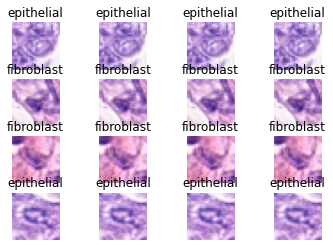

In [20]:
# Lets have a look at some of our images  
_, axes = plt.subplots(4, 4)
indices = np.random.choice(len(images), 16)
image_samples = images[indices]
label_samples = labels[indices]
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(image_samples[i])
        axes[i, j].axis('off')
        axes[i, j].set_title(str(id2class[label_samples[i]]))
plt.show()

### Image Preprocessing & Normalization 

In [19]:
test_size = int(len(labels) * 0.1)
val_size = int(len(labels) * 0.1)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=val_size, random_state=12)

train_images = train_images.astype('float32') / 255.
val_images = val_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(train_images.shape, train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(val_images.shape, val_labels.shape))
print('test_images shape: {} test_labels shape: {}'.format(test_images.shape, test_labels.shape))

train_images shape: (7918, 27, 27, 3) train_labels shape: (7918,)
val_images shape: (989, 27, 27, 3) val_labels shape: (989,)
test_images shape: (989, 27, 27, 3) test_labels shape: (989,)


### Baseline Model 

In [ ]:
model_CNN_1 = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model_CNN_1.summary()
model_CNN_1.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_CNN_1 = model_CNN_1.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=60,
    validation_data=(val_images, val_labels),
    verbose=1
)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               295040    
_________________________________________________________________
dense_60 (Dense)             (None, 4)               

In [ ]:
# Plot the learning curve 
def plot(hist_CNN_1):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['accuracy'], label='training')
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['loss'], label='training')
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

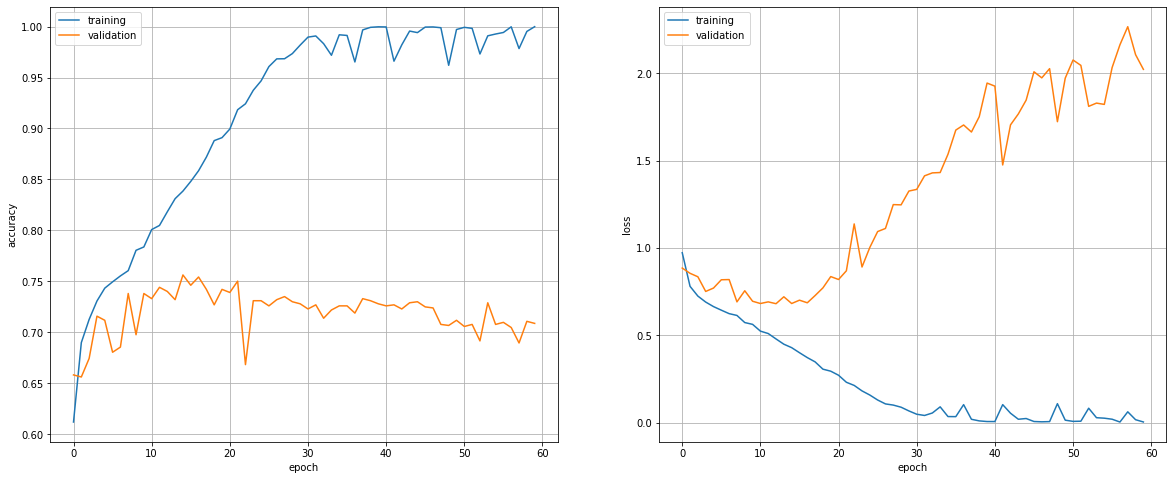

In [ ]:
plot(hist_CNN_1)

In [ ]:
val_loss, val_accuracy = model_CNN_1.evaluate(val_images, val_labels)
print('Test loss: {} Test accuracy: {}'.format(val_loss, val_accuracy))

y_pred = model_CNN_1.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 4ms/step - loss: 2.0232 - accuracy: 0.7088
Test loss: 2.023221492767334 Test accuracy: 0.7087967395782471
F1-score: 0.6713004696529032
[[153  20  24  20]
 [ 17 181  23  49]
 [ 28  18 297  12]
 [ 27  33  17  70]]


### VGG for cellType



check class weights 

In [18]:
# Print the current weight of the classes 
counter = train_label_df.cellType.value_counts()
count_dict = dict(zip(counter.index, counter.values))

total_samples = train_label_df.shape[0]
num_classes = len(count_dict)
mul_class_weights = {}
for class_id, cnt in count_dict.items():
    mul_class_weights[class_id] = total_samples / (num_classes * cnt)

print(mul_class_weights)

{2: 0.6065212061779848, 1: 0.9728666928824223, 0: 1.3103813559322033, 3: 1.784992784992785}


In [32]:
# Define VGG Architecture 
def VGG_c(input_shape, num_classes, include_top=True):
    """
    """
    model_vgg_1 = Sequential([
        # Input layer 
        Input(input_shape),

        # Layer 1
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 2
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Layer 3
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 4
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Flatening Layer
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.5),
    ])
    # sigmoid condition
    if include_top:
        model_vgg_1.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))
    return model_vgg_1

In [11]:
input_shape = (27, 27, 3)
model_VGG_1 = VGG_c(input_shape, 4) # 4 classes 
model_VGG_1.summary()

# Learning rate scheduler
learning_rate = 1e-3
#warmup_steps = 100
lr_drop = 25
epochs = 60
#batch_size_vgg=128

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)

# Data augmentation
data_aug = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

data_aug.fit(train_images)

model_VGG_1.compile(optimizer=optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_VGG_1 = model_VGG_1.fit(
    data_aug.flow(train_images, train_labels,batch_size=128),
    #batch_size=batch_size_vgg,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)       

In [12]:
# plot learning curve 
def plot(hist_VGG_1):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['accuracy'], label='training')
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['loss'], label='training')
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

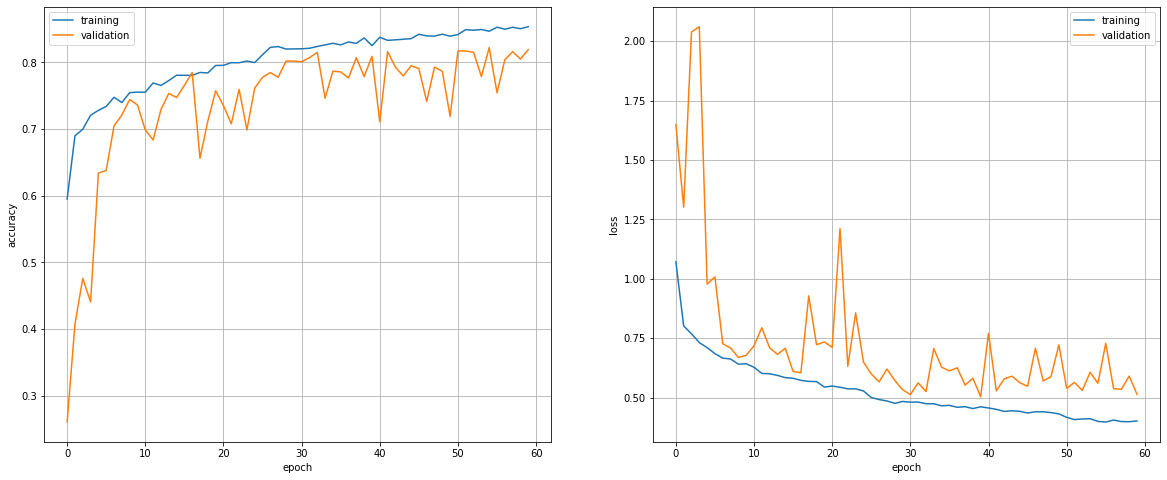

In [13]:
plot(hist_VGG_1)

In [15]:
val_loss, val_accuracy = model_VGG_1.evaluate(val_images, val_labels)
print('Test loss: {} Test accuracy: {}'.format(val_loss, val_accuracy))

y_pred = model_VGG_1.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
cm = confusion_matrix(val_labels, y_pred)
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 3ms/step - loss: 0.5138 - accuracy: 0.8190
Test loss: 0.5138236284255981 Test accuracy: 0.8190091252326965
F1-score: 0.7994936683215019
[[167  26   8  16]
 [  8 228   9  25]
 [ 14  21 310  10]
 [  7  23  12 105]]


In [16]:
# Plot Confusion Matrix (Adapted from sikit learn)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
cm_plot_labels = [ 'fibroblast','inflammatory','epithelial','others' ]

Confusion matrix, without normalization
[[167  26   8  16]
 [  8 228   9  25]
 [ 14  21 310  10]
 [  7  23  12 105]]


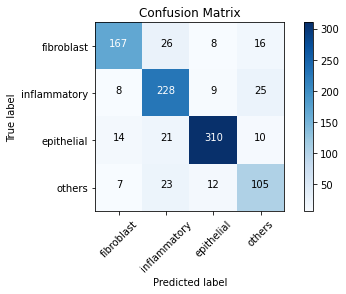

In [26]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Transfer Learning 

Train on extra dataset 

In [25]:
# data loader for transfer learning 
def load_data(label_df, image_dir):
    """Load data from given label data frame and image dir

    Args
    label_df:
    image_dir:

    Returns
    """
    image_dir = Path(image_dir)
    image_filenames = label_df.ImageName.values
    targets = label_df.isCancerous.values

    images = []
    labels = []
    for i in range(len(image_filenames)):
        filename = image_filenames[i]
        label = targets[i]

        image_path = image_dir / filename
        image = np.array(Image.open(image_path))
        images.append(image)
        labels.append(label)
    images = np.stack(images, 0)
    labels = np.stack(labels, 0)
    return images, labels

In [26]:
data_dir = Path('/content')
train_extra_label_path = data_dir / 'data_labels_extraData.csv'

train_extra_label_df = pd.read_csv(train_extra_label_path)

image_dir = data_dir / 'patch_images'
extra_images, extra_labels = load_data(train_extra_label_df, image_dir)

# Normalize
extra_labels = extra_labels.astype('int32')
print('images shape: {} labels shape: {}'.format(extra_images.shape, extra_labels.shape))

images shape: (10384, 27, 27, 3) labels shape: (10384,)


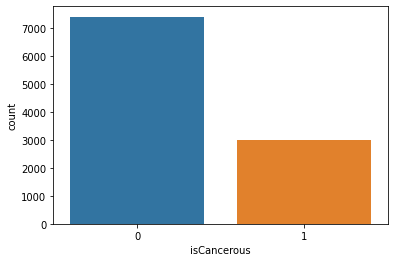

In [27]:
sns.countplot(x=train_extra_label_df.isCancerous)

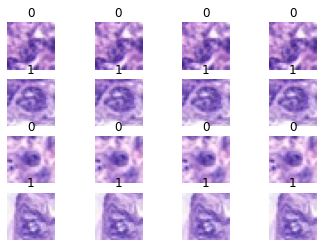

In [28]:
_, axes = plt.subplots(4, 4)
indices = np.random.choice(len(extra_images), 16)
image_samples = extra_images[indices]
label_samples = extra_labels[indices]
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(image_samples[i])
        axes[i, j].axis('off')
        axes[i, j].set_title(label_samples[i])
plt.show()

In [29]:
extra_train_images, extra_val_images, extra_train_labels, extra_val_labels = train_test_split(extra_images, extra_labels, test_size=0.1, shuffle=True, random_state=12)

extra_train_images = extra_train_images.astype('float32') / 255.
extra_val_images = extra_val_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(extra_train_images.shape, extra_train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(extra_val_images.shape, extra_val_labels.shape))

train_images shape: (9345, 27, 27, 3) train_labels shape: (9345,)
val_images shape: (1039, 27, 27, 3) val_labels shape: (1039,)


In [30]:
counter = train_extra_label_df.isCancerous.value_counts()
count_dict = dict(zip(counter.index, counter.values))

total_samples = train_extra_label_df.shape[0]
num_classes = len(count_dict)
class_weights = {}
for class_id, cnt in count_dict.items():
    class_weights[class_id] = total_samples / (num_classes * cnt)

print(class_weights)

{0: 0.7021909656478226, 1: 1.7364548494983278}


In [35]:
input_shape = (27, 27, 3)
model_training_vgg = VGG_c(input_shape, num_classes=1)
model_training_vgg.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 25
epochs = 60

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Data augmentation
data_mut = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)
checkpoint_dir = './pretrained_models'
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'trans_vgg_model_{epoch:03d}_{val_accuracy:.4f}.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_prefix,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True)

data_mut.fit(extra_train_images)
model_training_vgg.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg_transfer = model_training_vgg.fit(
    data_mut.flow(extra_train_images, extra_train_labels,batch_size=128),
    epochs=epochs,
    validation_data=(extra_val_images, extra_val_labels),
    verbose=1,
    callbacks=[reduce_lr, checkpoint],
    class_weight=class_weights
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)       

In [36]:
def load_weights(model_dir, best=True):
    """
    """
    weight_files = os.listdir(model_dir)
    if best:
        weight_file = os.path.join(model_dir, sorted(weight_files, key=lambda x: float(x.split('_')[-1][:-3]))[::-1][0])
    else:
        weight_file = os.path.join(model_dir, weight_files[-1])
    return weight_file

In [64]:
input_shape = (27, 27, 3)
model_dir = './pretrained_models'
weight_file = load_weights(model_dir)
print('Loading from {}'.format(weight_file))

trans_model = VGG_c(input_shape, 1)
trans_model.load_weights(weight_file)
trans_model = VGG_c(input_shape, 4, include_top=False)

for i in range(len(trans_model.layers)):
    if len(trans_model.layers[i].get_weights()) > 0:
        print(trans_model.layers[i].name)
        trans_model.layers[i].set_weights(trans_model.layers[i].get_weights())

        # Sanity check
        if len(trans_model.layers[i].get_weights()) > 0:
            for j in range(len(trans_model.layers[i].get_weights())):
                assert np.sum(np.abs(trans_model.layers[i].get_weights()[j] - trans_model.layers[i].get_weights()[j])) < 1e-5

for layer in trans_model.layers:
    layer.trainable = True

inputs = Input(input_shape)
x = trans_model(inputs, training=False)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.1)(x)
outputs = Dense(4, activation='softmax')(x)


model = tf.keras.Model(inputs, outputs)
model.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 25
epochs = 60


def lr_scheduler(epoch):
    decay_lr =  learning_rate * (0.1 ** (epoch // lr_drop))
    print('Learning rate: {}'.format(decay_lr))
    return decay_lr

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)

# Data augmentation
data_mut = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

data_mut.fit(train_images)
model.compile(optimizer=optimizers.Adam(learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
fine_tune_hist = model.fit(
    data_mut.flow(train_images, train_labels,batch_size=128),
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr, lr_reducer],
    # class_weight=class_weights,
)

Loading from ./pretrained_models/trans_vgg_model_049_0.9423.h5
conv2d_136
batch_normalization_136
conv2d_137
batch_normalization_137
conv2d_138
batch_normalization_138
conv2d_139
batch_normalization_139
dense_81
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 27, 27, 3)]       0         
_________________________________________________________________
sequential_34 (Sequential)   (None, 128)               361376    
_________________________________________________________________
dense_82 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 4)                 260       
Total params: 369,892
Trainable params: 369,

In [66]:
print("Number of layers in the base model: ", len(trans_model.layers))
fine_tune_at = 9
for layer in trans_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=optimizers.Adam(learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
fine_tune_hist = model.fit(
    data_mut.flow(train_images, train_labels,batch_size=128),
    epochs=10,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr, lr_reducer],
    
)

Number of layers in the base model:  17
Epoch 1/10
Learning rate: 0.001
62/62 [==============================] - 3s 49ms/step - loss: 0.4544 - accuracy: 0.8291 - val_loss: 0.5886 - val_accuracy: 0.7927
Epoch 2/10
Learning rate: 0.001
62/62 [==============================] - 3s 46ms/step - loss: 0.4482 - accuracy: 0.8294 - val_loss: 0.5946 - val_accuracy: 0.7937
Epoch 3/10
Learning rate: 0.001
62/62 [==============================] - 3s 45ms/step - loss: 0.4369 - accuracy: 0.8335 - val_loss: 0.5666 - val_accuracy: 0.7887
Epoch 4/10
Learning rate: 0.001
62/62 [==============================] - 3s 45ms/step - loss: 0.4490 - accuracy: 0.8311 - val_loss: 0.5895 - val_accuracy: 0.7907
Epoch 5/10
Learning rate: 0.001
62/62 [==============================] - 3s 47ms/step - loss: 0.4360 - accuracy: 0.8310 - val_loss: 0.5788 - val_accuracy: 0.7978
Epoch 6/10
Learning rate: 0.001
62/62 [==============================] - 3s 45ms/step - loss: 0.4309 - accuracy: 0.8357 - val_loss: 0.5942 - val_accur

In [65]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print('Test loss: {} Test accuracy: {}'.format(val_loss, val_accuracy))

y_pred = model.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.8049
Test loss: 0.555767297744751 Test accuracy: 0.8048533797264099
F1-score: 0.7796791833208447
[[168  21  18  10]
 [ 12 223  13  22]
 [ 17  18 315   5]
 [ 13  29  15  90]]


#### **Baseline Model Building** (nathan)

In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

# Hyper-parameter determining the number of hidden layers; can be tuned
HIDDEN_LAYER_DIM = 100

In [ ]:
# Building the layers of the neural network model
base_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               218800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 219,002
Trainable params: 219,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.compile(optimizer = 'SGD',
                   loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
                   metrics = ['categorical_accuracy'])

In [ ]:
base_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs = 30, verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


#### **Performance Measure**

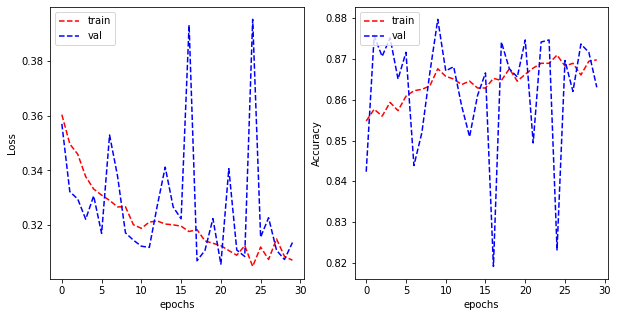

In [ ]:
plot_learning_curve(base_history.history['loss'], base_history.history['val_loss'], 
                    base_history.history['categorical_accuracy'], base_history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

The model can be seen to have overfitting when plotted for both loss and accuracy.

#### **Predictions on Test Set**
The baseline model is applied to the test dataset and predicts whether images are cancerous or non-cancerous. The model was evaluated to have a loss of 30.76% and an accuracy of 87.63%.

In [ ]:
base_model.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.3170 - categorical_accuracy: 0.8763


[0.31696227192878723, 0.8762626051902771]

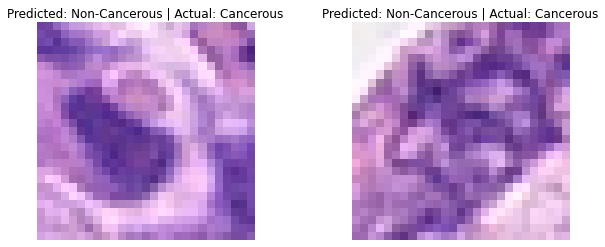

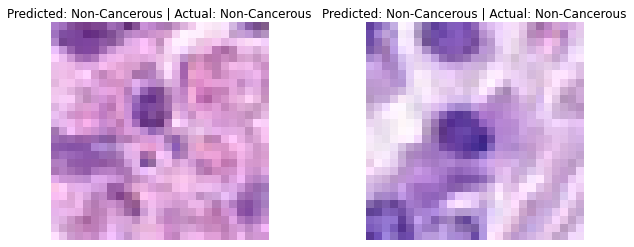

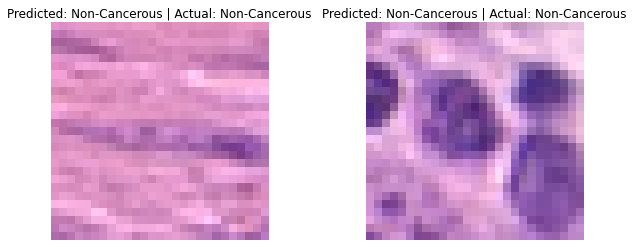

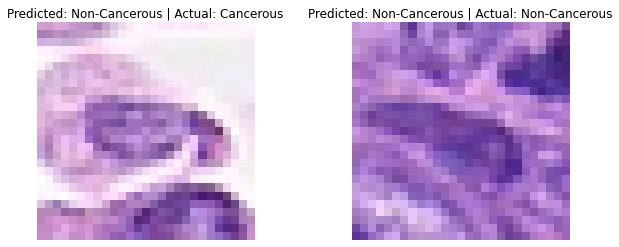

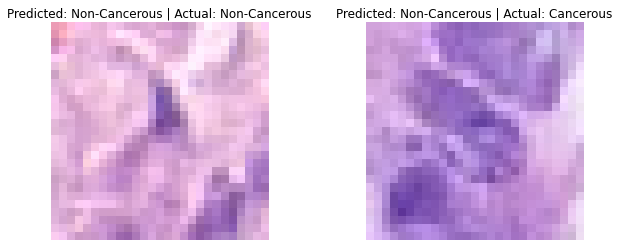

In [ ]:
# Examples of the predicted results against the actual data on the test set
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

z = 0
while z < 5:
  d_inv = {v: k for k, v in label_names.items()}
  plt.figure(figsize=(16, 4))
  batches = 0
  for x, y in test_generator:
          batches = batches + 1
          y_hat = model.predict(x, verbose=0)
          x = np.squeeze(x)
          if batches < 3:
              plt.subplot(1, 3, batches)
              plt.imshow(x)
              plt.title("Predicted: {} | Actual: {}".format(d_inv[np.argmax(y_hat[0])], d_inv[np.argmax(y[0])]))
              
          else:
              break
          
          plt.axis('off')

  z = z + 1

## Adding Regularisation

In [ ]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3d1cfcac20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
plot_learning_curve(history_reg.history_reg['loss'], history_reg.history_reg['val_loss'], 
                    history_reg.history_reg['categorical_accuracy'], history_reg.history_reg['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Bayesian Convolutional Neural Network
 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

#### **Bayesian Model Building**

In [ ]:
import tensorflow_probability as tfp

divergence_fn = lambda q,p,_:tfp.distributions.kl_divergence(q,p)/3457

model_bayes = tf.keras.Sequential([
    
    tfp.layers.Convolution2DReparameterization(input_shape = (27, 27, 3), filters = 8, kernel_size = 16, activation = 'relu',
                                                kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                                kernel_divergence_fn = divergence_fn,
                                                bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
                                                bias_divergence_fn = divergence_fn
                                            ),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tfp.layers.DenseReparameterization(units = tfp.layers.OneHotCategorical.params_size(2), activation = None,
                                        kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        kernel_divergence_fn = divergence_fn,
                                        bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        bias_divergence_fn = divergence_fn
                                    ),
    tfp.layers.OneHotCategorical(2)
])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
model_bayes.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_2  (None, 12, 12, 8)         12304     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          2336      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [ ]:
from tensorflow.keras.optimizers import Adam

model_bayes.compile(loss = negative_log_likelihood,
                    optimizer = Adam(learning_rate=0.005),
                    metrics = ['accuracy'],
                    experimental_run_tf_function = False)

#### **Performance Measure**

In [ ]:
history_bayes = model_bayes.fit(train_generator, validation_data = validation_generator, epochs = 10, verbose = 1)

Epoch 1/10
220/220 [==============================] - 9s 35ms/step - loss: 5.2750 - accuracy: 0.5019 - val_loss: 4.5585 - val_accuracy: 0.5068
Epoch 2/10
220/220 [==============================] - 7s 34ms/step - loss: 3.9142 - accuracy: 0.5001 - val_loss: 3.2797 - val_accuracy: 0.5159
Epoch 3/10
220/220 [==============================] - 8s 34ms/step - loss: 2.9160 - accuracy: 0.5142 - val_loss: 2.5533 - val_accuracy: 0.5124
Epoch 4/10
220/220 [==============================] - 8s 34ms/step - loss: 2.3558 - accuracy: 0.5157 - val_loss: 2.1760 - val_accuracy: 0.5189
Epoch 5/10
220/220 [==============================] - 7s 34ms/step - loss: 2.0458 - accuracy: 0.5114 - val_loss: 1.9156 - val_accuracy: 0.5099
Epoch 6/10
220/220 [==============================] - 8s 34ms/step - loss: 1.8092 - accuracy: 0.5188 - val_loss: 1.7001 - val_accuracy: 0.5447
Epoch 7/10
220/220 [==============================] - 7s 34ms/step - loss: 1.6528 - accuracy: 0.5235 - val_loss: 1.5550 - val_accuracy: 0.5296

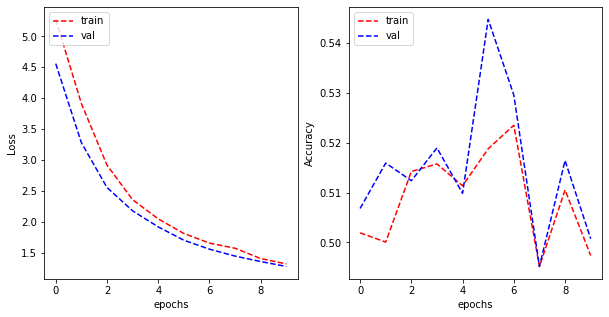

In [ ]:
plot_learning_curve(history_bayes.history['loss'], history_bayes.history['val_loss'], 
                    history_bayes.history['accuracy'], history_bayes.history['val_accuracy'], 
                    metric_name = 'Accuracy')

#### **Predictions on Test Set**

In [ ]:
model_bayes.evaluate(test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 1.2729 - accuracy: 0.5051


[1.2728500366210938, 0.5050504803657532]